<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (10,6)


In [ ]:
#Установим индекс таблицы равным столбцу datetime, изменим тип данных и прочитаем таблицу
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
#ресемплирование данных по одному часу
df = df.resample('1H').sum()

## Анализ

In [ ]:
#рассмотрим таблиу
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Размер таблии 4416 строк × 1 колонка

In [ ]:
#рассмотрим таблиу методом info()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


тип колонки int64, DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00

In [ ]:
#рассмотрим таблиу методом describe()
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Рассмотрим статистические данные

In [ ]:
#проверим, в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)

True


порядок соблюдён

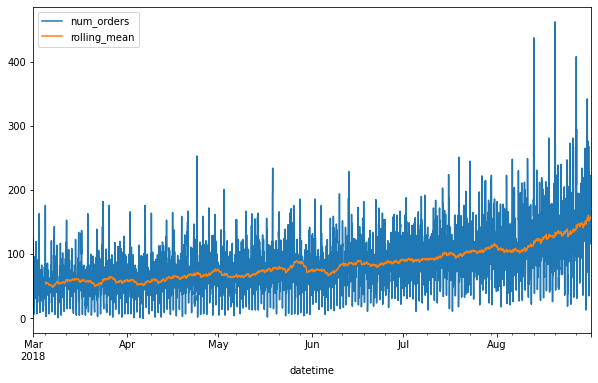

In [ ]:
#С помощью скользящего среднего и скользящего среднего отклонения посмотрим значения,
#которые меньше всего подвержены колебаниям

df['rolling_mean'] = df.rolling(100).mean()
df.plot()
plt.show()

Ряд стал более стаионарным, а значит данные можно прогназировать

In [ ]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


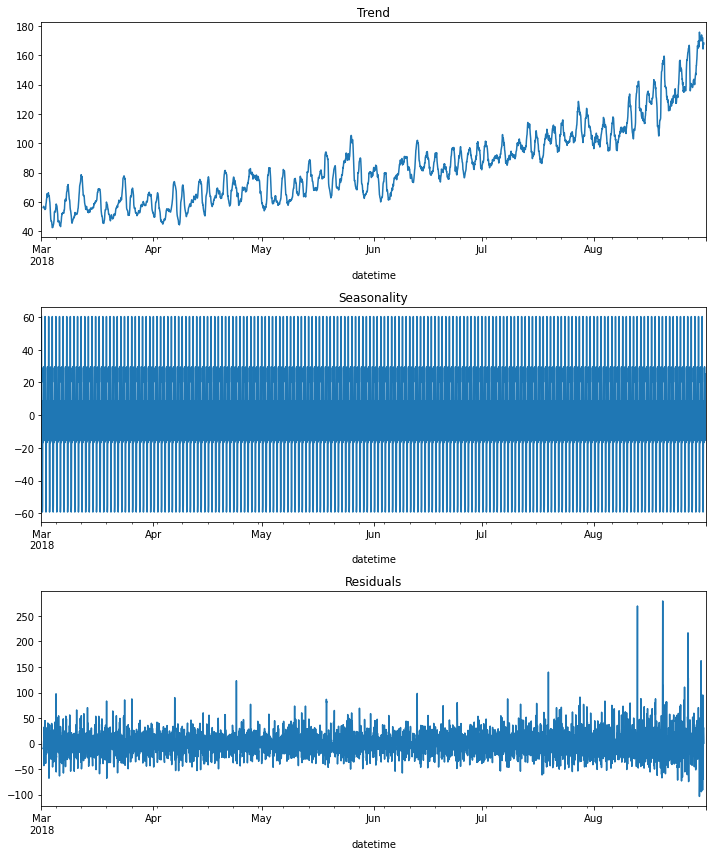

In [ ]:
#Разложим ряд на тренд, сезонность и остаток
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(10, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca()
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графика тренд видно, что увеличение спроса на такси сезонно и приходится на летнии месяци

In [ ]:
#Создадим признаки
def make_features(df, max_lag, rolling_mean_size):
    #df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(df, 4, 4)
print(df.head())

                     num_orders  rolling_mean  day  dayofweek  hour  lag_1  \
datetime                                                                     
2018-03-01 00:00:00         124           NaN    1          3     0    NaN   
2018-03-01 01:00:00          85           NaN    1          3     1  124.0   
2018-03-01 02:00:00          71           NaN    1          3     2   85.0   
2018-03-01 03:00:00          66           NaN    1          3     3   71.0   
2018-03-01 04:00:00          43          86.5    1          3     4   66.0   

                     lag_2  lag_3  lag_4  
datetime                                  
2018-03-01 00:00:00    NaN    NaN    NaN  
2018-03-01 01:00:00    NaN    NaN    NaN  
2018-03-01 02:00:00  124.0    NaN    NaN  
2018-03-01 03:00:00   85.0  124.0    NaN  
2018-03-01 04:00:00   71.0   85.0  124.0  



Убрал признаки за год и месяц, из-за периода они неважны, добавил призна за час

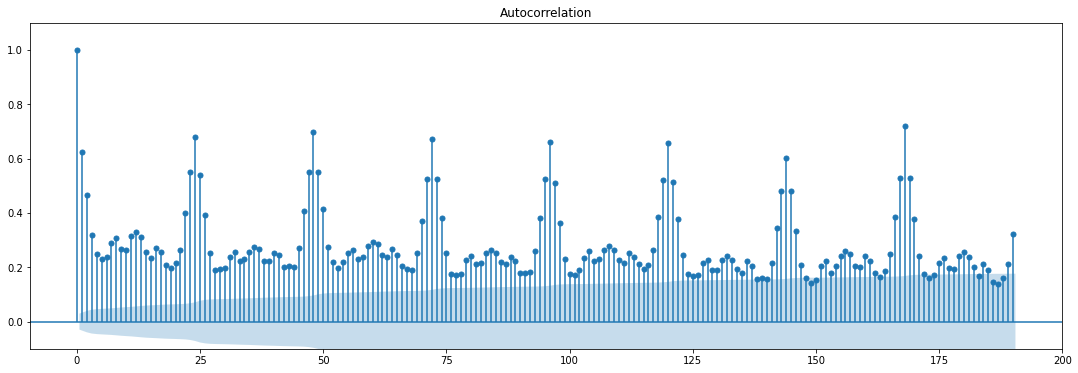

In [ ]:

from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4412 non-null   float64
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   hour          4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 345.0 KB


таблиа после создания дополнительных признаков float64(5), int64(5)

Вывод:
- Установили  индекс таблицы равным столбцу datetime, изменили тип данных
- ресемплировали данных по одному часу
- хронологический порядк расположения даты и время соблюдён
- С помощью сользящего среднео ряд стал более стаионарным, а значит данные можно прогназировать
- Из графика тренд видно, что увеличение спроса на такси сезонно и приходится на летнии месяци
- Создали дополнительные признаки
- таблиа после создания дополнительных признаков float64(5), int64(5)

## Обучение

In [ ]:
#Разабьём датасет на обучающую и тестовую выборки, тестовая выборка размером 10%
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
#После деления данных на выборки удалим пропуски способом dropna()
train = train.dropna()
test = test.dropna()

In [ ]:
#проверим размер выборок
print(train.shape)
print(test.shape)

(3970, 9)
(442, 9)


In [ ]:
#выделим признаки и целевой признак
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

**RandomForestRegressor**

In [ ]:
model = RandomForestRegressor()
params = {
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'random_state' : [123]
    }
grid_cv = GridSearchCV(estimator=model, cv=tscv, param_grid=params, n_jobs=-1, verbose=10, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
grid_cv.best_params_
rf_rmse = (-grid_cv.best_score_) ** 0.5
print('Train RMSE: {:.2f}'.format(rf_rmse))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=3, n_estimators=10, random_state=123..............
[CV 1/5; 1/9] END max_depth=3, n_estimators=10, random_state=123; total time=   0.0s
[CV 2/5; 1/9] START max_depth=3, n_estimators=10, random_state=123..............
[CV 2/5; 1/9] END max_depth=3, n_estimators=10, random_state=123; total time=   0.0s
[CV 3/5; 1/9] START max_depth=3, n_estimators=10, random_state=123..............
[CV 3/5; 1/9] END max_depth=3, n_estimators=10, random_state=123; total time=   0.0s
[CV 4/5; 1/9] START max_depth=3, n_estimators=10, random_state=123..............
[CV 4/5; 1/9] END max_depth=3, n_estimators=10, random_state=123; total time=   0.0s
[CV 5/5; 1/9] START max_depth=3, n_estimators=10, random_state=123..............
[CV 5/5; 1/9] END max_depth=3, n_estimators=10, random_state=123; total time=   0.0s
[CV 1/5; 2/9] START max_depth=3, n_estimators=20, random_state=123..............
[CV 1/5; 2/9] END max_depth=3

<div class="alert alert-info">
Задал кросс-валидацию TimeSeriesSplit.
</div>

RMSE для RandomForestRegressor = 31.64

**LGBMRegressor**

In [ ]:
# создадим кросс-валидатор для последующего обучения моделей
#cv = KFold(n_splits=3, shuffle=True, random_state=12345)

In [ ]:
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=12345)
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100, 200],
    'max_depth' :[1],#[5, 7, 10],
    'verbose' : [-1],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' :[30, 130, 200]
}

gs_gbm =  GridSearchCV(lgbm,params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=10)
gs_gbm.fit(features_train, target_train)
predictions_valid = gs_gbm.predict(features_train)
gbm_rmse = (-gs_gbm.best_score_) ** 0.5
print('Train RMSE: {:.2f}'.format(gbm_rmse))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START boosting_type=gbdt, force_col_wise=True, max_depth=1, n_estimators=50, num_leaves=30, random_state=12345, verbose=-1
[CV 1/5; 1/9] END boosting_type=gbdt, force_col_wise=True, max_depth=1, n_estimators=50, num_leaves=30, random_state=12345, verbose=-1; total time=   0.0s
[CV 2/5; 1/9] START boosting_type=gbdt, force_col_wise=True, max_depth=1, n_estimators=50, num_leaves=30, random_state=12345, verbose=-1
[CV 2/5; 1/9] END boosting_type=gbdt, force_col_wise=True, max_depth=1, n_estimators=50, num_leaves=30, random_state=12345, verbose=-1; total time=   0.5s
[CV 3/5; 1/9] START boosting_type=gbdt, force_col_wise=True, max_depth=1, n_estimators=50, num_leaves=30, random_state=12345, verbose=-1
[CV 3/5; 1/9] END boosting_type=gbdt, force_col_wise=True, max_depth=1, n_estimators=50, num_leaves=30, random_state=12345, verbose=-1; total time=   0.7s
[CV 4/5; 1/9] START boosting_type=gbdt, force_col_wise=True, max


Вывод:
- лучшая модель - LGBMRegressor
- RMSE для LGBMRegressor = 25.02

## Тестирование

In [ ]:
predict_lgb_test = gs_gbm.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, predict_lgb_test)**0.5

RMSE для LGBMRegressor на тестовой выборе = 41.8447575177758

Вывод:
- Мы провели анализ и подготовили данные для моделей. Обучили разные модели. Путем проверки обученных моделей, пришли к выводу, что модель LGBMRegressor дает лучшие показатели RMSE.

### Общий вывод:
- Установили  индекс таблицы равным столбцу datetime, изменили тип данных
- ресемплировали данных по одному часу
- хронологический порядк расположения даты и время соблюдён
- С помощью сользящего среднео ряд стал более стаионарным, а значит данные можно прогназировать
- Из графика тренд видно, что увеличение спроса на такси сезонно и приходится на летнии месяци
- Создали дополнительные признаки
- таблиа после создания дополнительных признаков float64(5), int64(5)
- RMSE для RandomForestRegressor = 31.64
- лучшая модель - LGBMRegressor
- RMSE для LGBMRegressor = 25.02
- RMSE для LGBMRegressor на тестовой выборке = 41.84
- Мы провели анализ и подготовили данные для моделей. Обучили разные модели. Путем проверки обученных моделей, пришли к выводу, что модель LGBMRegressor дает лучшие показатели RMSE.